# グラフオートエンコーダのテスト
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/autoencoder.py

In [1]:
# 前処理の定義
import torch
import torch_geometric.transforms as T

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])

transformの説明(ChatGPT)

`transform` は、PyTorch Geometricのデータセットに対して前処理や変換を行う際に使うオブジェクトです。このオブジェクトは、データセットに適用する一連の変換処理（`transforms`）を定義します。`T.Compose()` を使うことで、複数の変換をまとめて一つの処理として適用できるようになります。

### `T.Compose()`
- これは、複数の変換を順番に適用するための関数です。`transform`に渡すことで、指定した変換をデータセットに順に適用します。

### `T.NormalizeFeatures()`
- 各ノードの特徴量を正規化します。たとえば、ノードの特徴ベクトルの大きさを統一したり、各次元の値を0から1の範囲に収める処理を行います。

### `T.ToDevice(device)`
- データを指定されたデバイス（CPUまたはGPU）に転送します。`device`は事前に指定されているデバイス（例: `'cpu'` や `'cuda'`）です。

### `T.RandomLinkSplit()`
- グラフに含まれるエッジをランダムに分割して、トレーニング用、検証用、テスト用のデータセットを作成します。
    - `num_val=0.05`: エッジの5%を検証用データに使います。
    - `num_test=0.1`: エッジの10%をテスト用データに使います。
    - `is_undirected=True`: グラフが無向グラフであることを指定します。エッジの順序を考慮せず、無向として扱います。
    - `split_labels=True`: 分割の際に、エッジラベル（リンクの有無）も分ける設定です。
    - `add_negative_train_samples=False`: トレーニングデータに負のサンプル（リンクが存在しないノードペア）を追加しません。

### まとめ
この`transform`は、データセットを次のステップで使えるようにするための前処理を行います。まずノードの特徴量を正規化し、データをGPUに移し、エッジをランダムに分割してトレーニング、検証、テスト用のセットを作成しています。

In [46]:
# データの読み込み
from torch_geometric.datasets import Planetoid

dataset = Planetoid('/tmp/Cora', name='Cora', transform=transform)
train_data, val_data, test_data = dataset[0]

In [18]:
# モデルの定義
from torch_geometric.nn import GAE, GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

in_channels, out_channels = dataset.num_features, 16
model = GAE(GCNEncoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)

    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

Epoch: 001, AUC: 0.6806, AP: 0.7183
Epoch: 002, AUC: 0.6807, AP: 0.7183
Epoch: 003, AUC: 0.6813, AP: 0.7196
Epoch: 004, AUC: 0.6833, AP: 0.7212
Epoch: 005, AUC: 0.6843, AP: 0.7228
Epoch: 006, AUC: 0.6846, AP: 0.7237
Epoch: 007, AUC: 0.6842, AP: 0.7245
Epoch: 008, AUC: 0.6827, AP: 0.7242
Epoch: 009, AUC: 0.6818, AP: 0.7244
Epoch: 010, AUC: 0.6813, AP: 0.7244
Epoch: 011, AUC: 0.6810, AP: 0.7242
Epoch: 012, AUC: 0.6804, AP: 0.7240
Epoch: 013, AUC: 0.6803, AP: 0.7241
Epoch: 014, AUC: 0.6803, AP: 0.7237
Epoch: 015, AUC: 0.6809, AP: 0.7229
Epoch: 016, AUC: 0.6824, AP: 0.7222
Epoch: 017, AUC: 0.6846, AP: 0.7221
Epoch: 018, AUC: 0.6864, AP: 0.7225
Epoch: 019, AUC: 0.6879, AP: 0.7229
Epoch: 020, AUC: 0.6902, AP: 0.7233
Epoch: 021, AUC: 0.6966, AP: 0.7244
Epoch: 022, AUC: 0.7066, AP: 0.7271
Epoch: 023, AUC: 0.7173, AP: 0.7314
Epoch: 024, AUC: 0.7261, AP: 0.7346
Epoch: 025, AUC: 0.7290, AP: 0.7355
Epoch: 026, AUC: 0.7313, AP: 0.7361
Epoch: 027, AUC: 0.7348, AP: 0.7366
Epoch: 028, AUC: 0.7329, AP:

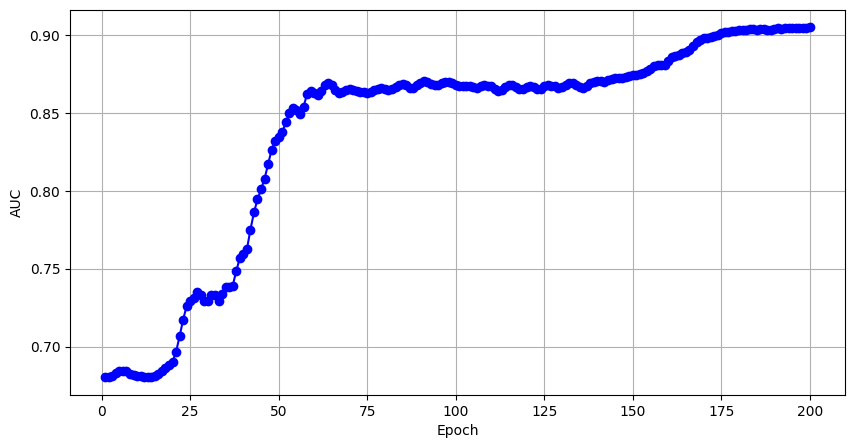

In [19]:
# 学習
import time
import matplotlib.pyplot as plt

epochs = 200
times = []
auc_history = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    auc_history.append(auc)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# AUCの変化の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), auc_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

## 検証

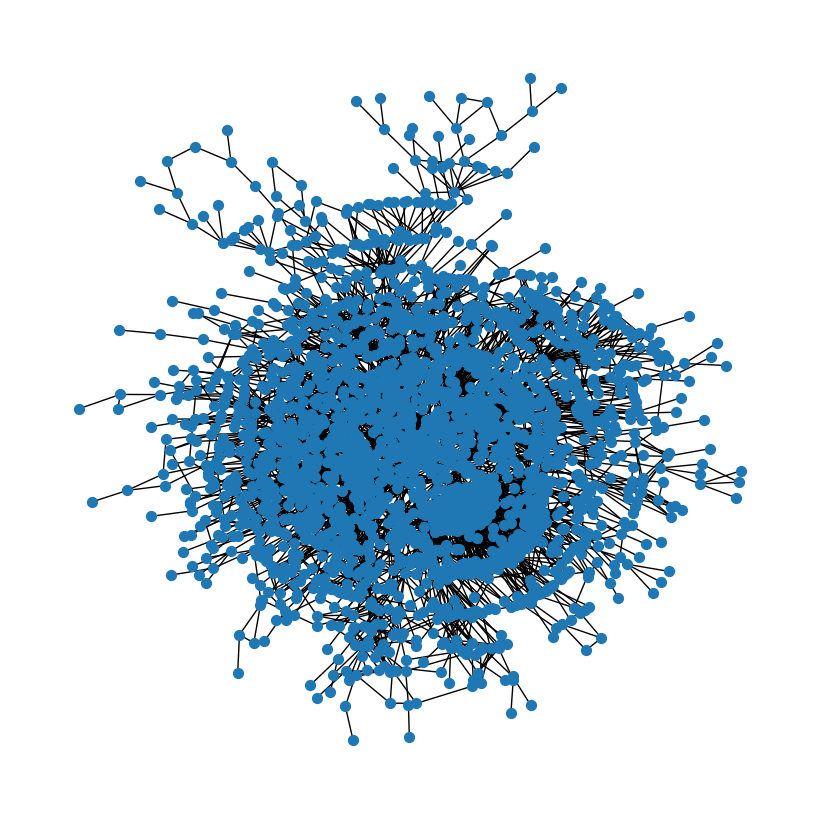

In [27]:
# 可視化
# graphvizバージョン
import networkx as nx
import torch_geometric

G = torch_geometric.utils.convert.to_networkx(train_data, to_undirected=True)

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=nx.nx_pydot.graphviz_layout(G_draw), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

In [49]:
z = model.encode(test_data.x, test_data.edge_index)
z.shape

torch.Size([2708, 16])

# 再構成

In [50]:
# 隣接行列（っぽいもの）を算出
# https://qiita.com/maskot1977/items/a4bc261a52dab27dec9a
prob_adj = z @ z.T
prob_adj = prob_adj - torch.diagonal(prob_adj)
prob_adj.shape

torch.Size([2708, 2708])

In [36]:
# 閾値以上を隣接するとする
threshold = 1
data = train_data.clone()
data.edge_index = (prob_adj >= threshold).nonzero(as_tuple=False).t()

In [34]:
# 可視化
# graphvizバージョン

def visualize_graph(data):
	G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

	# 最大連結成分のみ
	largest_cc = max(nx.connected_components(G), key=len)
	G_draw = G.subgraph(largest_cc)

	# グラフ描画
	plt.figure(figsize=(8,8)) # 適切なサイズで
	nx.draw(G_draw, pos=nx.nx_pydot.graphviz_layout(G_draw), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
	plt.show()

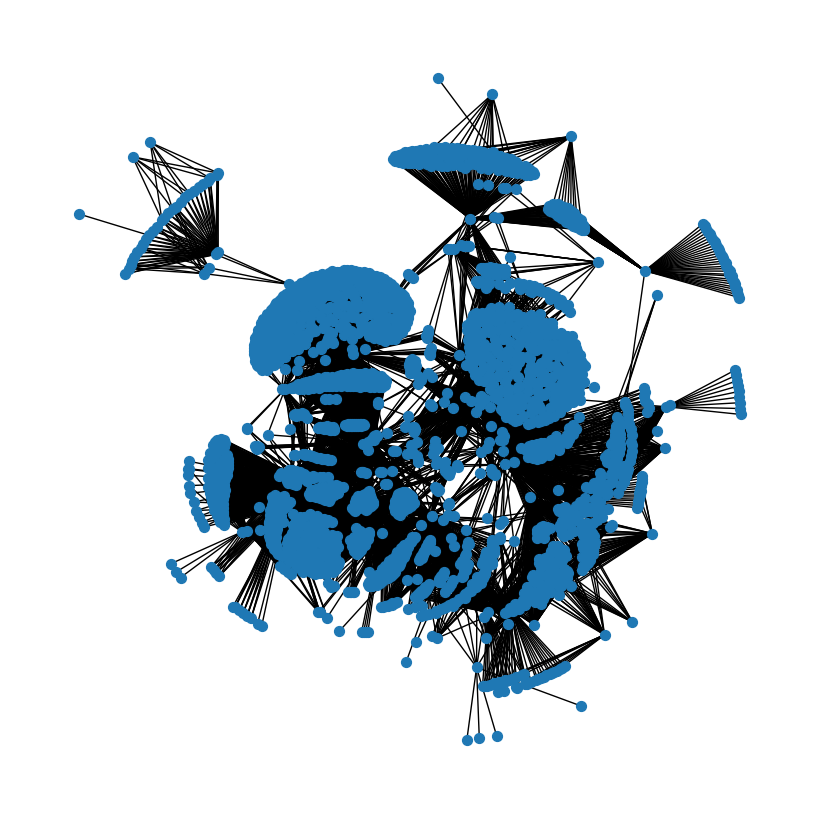

In [37]:
visualize_graph(data)

もとのグラフと似ていればいい感じ

グラフが大きすぎて分からない

# 埋め込みの可視化

In [51]:
# 描画する関数
def plot_points(z, colors, num_classes):
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]

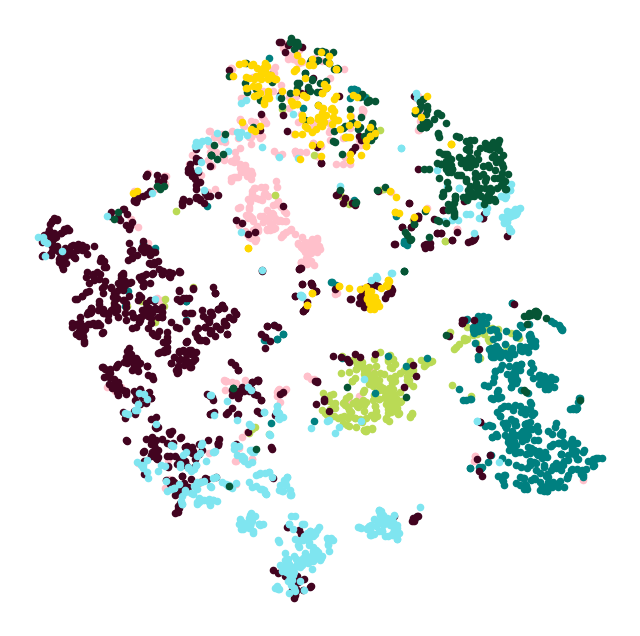

In [52]:
# TSNEを使うパターン
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    z_transformed = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    plot_points(z_transformed, colors, dataset.num_classes)

同じクラスが近くに固まっていればいい感じ

だいたい近くに固まっている

比較用に、Node2Vecで求めた埋め込み

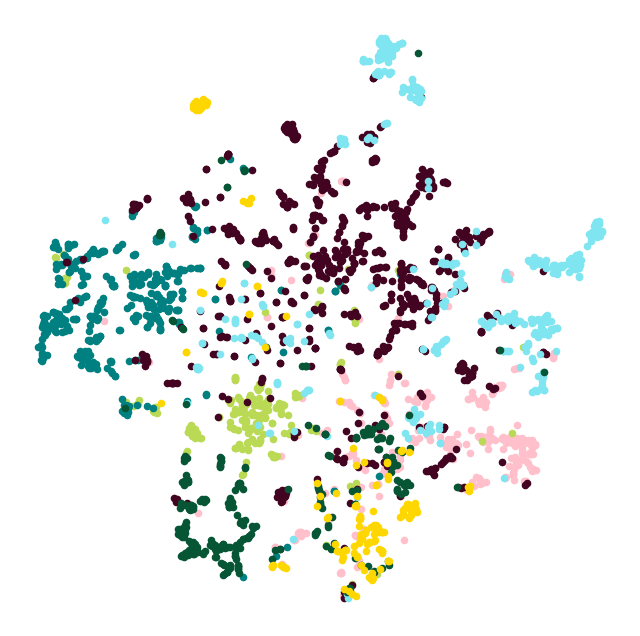